<a href="https://colab.research.google.com/github/c0natus/Paper-review-implements/blob/main/RecSys/AutoRec_Autoencoders_Meet_Collaborative_Filtering%2C_2015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall imgaug -y
!pip install imgaug==0.2.6
!pip install matplotlib --upgrade

# 초기 세팅

In [1]:
import os
import subprocess

import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

print(f'matplotlib version : {mpl.__version__}')

matplotlib version : 3.2.2


In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2022-02-16 15:00:45--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2022-02-16 15:00:46 (8.58 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [3]:
file_path = os.path.join(os.getcwd(), 'ml-latest-small', 'ratings.csv')
ml_small_df = pd.read_csv(file_path, encoding='utf-8')

# 1. 데이터 분석

In [ ]:
ml_small_df.sample(5)

,userId,movieId,rating,timestamp
45651,302,58,5.0,854472122
52201,339,45210,4.5,1460183777
93393,599,2382,1.5,1498504291
82914,525,31658,4.0,1476476503
34051,232,3809,3.5,1078875782


In [ ]:
ml_small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
ml_small_df.describe(include='all')

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [ ]:
movieId_count = ml_small_df['movieId'].value_counts().sort_index()
movieId_count.describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: movieId, dtype: float64

In [ ]:
ml_small_df['movieId'].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
86279       1
86922       1
5962        1
87660       1
163981      1
Name: movieId, Length: 9724, dtype: int64

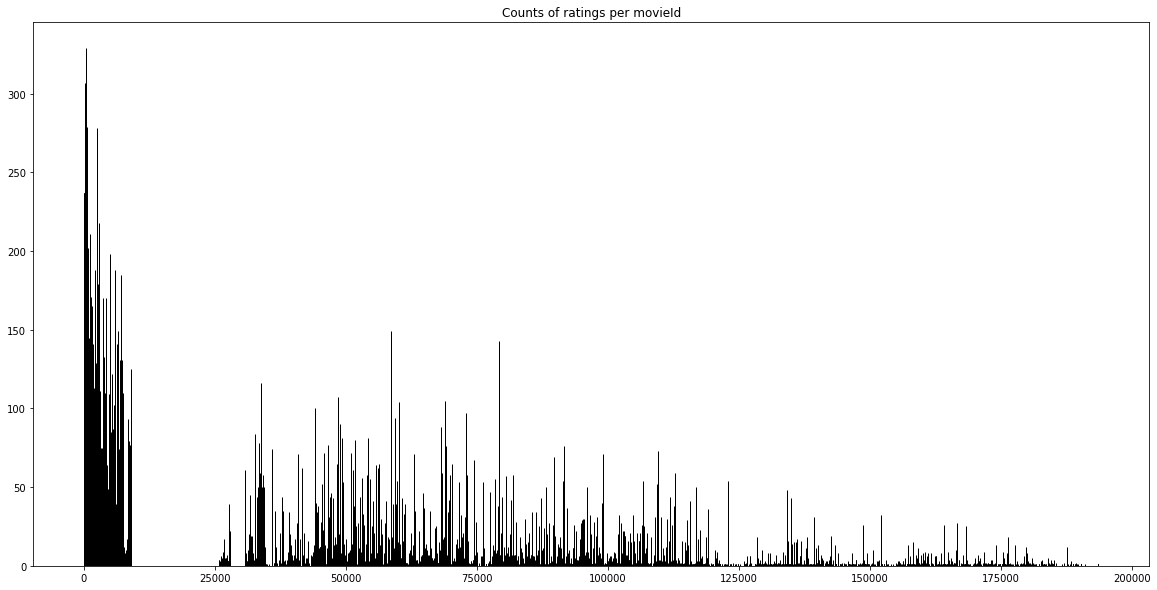

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.set_title('Counts of ratings per movieId')

ax.bar(
    movieId_count.index, 
    movieId_count,
    edgecolor='black'
    )

plt.show()

# 2. Data 전처리

In [4]:
def encode(data):
    userId_label_encoder = LabelEncoder()
    movieId_label_encoder = LabelEncoder()

    data['encoded_userId'] = userId_label_encoder.fit_transform(data['userId'].values)
    data['encoded_movieId'] = movieId_label_encoder.fit_transform(data['movieId'].values)
    
    return data, userId_label_encoder, movieId_label_encoder

ml_small_df, userId_label_encoder, movieId_label_encoder = encode(ml_small_df)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, train = True, train_size=0.8):

        self._all_data = data
        
        self.num_users = len(self._all_data['encoded_userId'].unique())
        self.num_movies = len(self._all_data['encoded_movieId'].unique())
        
        self.data = self._data_split(train, train_size)
        self.matrix = self._make_matrix(train)

    
    def _make_matrix(self, train):
        users = np.array(self.data['encoded_userId'].values)
        movies = np.array(self.data['encoded_movieId'].values)
        ratings = np.array(self.data['rating'].values)

        if train:
            matrix = np.zeros((self.num_movies, self.num_users)) - 1
        else:
            matrix = np.zeros((self.num_movies, self.num_users)) + 3
        
        for user, movie, rating in zip(users, movies, ratings):
            matrix[movie][user] = rating

        return matrix

    
    def _data_split(self, train, train_size):
        train_data, test_data = train_test_split(
            self._all_data, 
            test_size=1-train_size, 
            train_size=train_size, 
            stratify = self._all_data['encoded_userId'].values, 
            random_state=42)

        if train:
            return train_data
        else:
            return test_data

    
    def __len__(self):
        return self.matrix.shape[0]
    

    def __getitem__(self, idx):
        return torch.tensor(self.matrix[idx]).float()
        

In [6]:
ml_small_train_dataset = CustomDataset(data=ml_small_df, train=True, train_size=0.9)
ml_small_test_dataset =  CustomDataset(data=ml_small_df, train=False, train_size=0.9)

# 2. DataLoader

In [7]:
batch_size = 256

train_iter = DataLoader(dataset=ml_small_train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(dataset=ml_small_test_dataset, batch_size=batch_size, shuffle=False)

# 3. Model

In [8]:
class AutoRec(nn.Module):
    """
    Item-based AutoRec
    논문에서 encoder의 활성함수로 sigmoid, decoder의 활성함수로 identity 사용
    """
    def __init__(self, num_hiddens, num_users):
        super(AutoRec, self).__init__()
        self.encoder = nn.Sequential(
                                        nn.Linear(in_features=num_users, out_features=num_hiddens, bias=True),
                                        nn.Sigmoid(),
                                    )
        self.decoder = nn.Sequential(
                                        nn.Linear(in_features=num_hiddens, out_features=num_users, bias=True),
                                        nn.Identity(),
                                    )
        
        self.model = nn.ModuleList([self.encoder, self.decoder])

    
    def forward(self, batch_data):
        operand = batch_data
        
        mask = batch_data >= 0

        for operation in self.model:
            result = operation(operand)
            operand = result
        
        return result

# 4. 학습

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
learning_rate = 1e-3
num_hiddens = 500
weight_decay = 1e-3
num_users = len(ml_small_df['encoded_userId'].unique())

model = AutoRec(num_hiddens=num_hiddens, num_users=num_users)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

In [19]:
def funcTrain(model, train_iter, criterion, optimizer, device):
    model.train() # to train mode
    total_train_loss = 0

    for train_matrix in train_iter:
        train_matrix = train_matrix.to(device)

        prediction = model(train_matrix)

        mask = train_matrix >= 0
        prediction.register_hook(lambda grad: grad * mask.float())

        train_loss = criterion(prediction[mask], train_matrix[mask])

        # Update
        optimizer.zero_grad()   # reset gradient 
        train_loss.backward()   # backpropagate
        optimizer.step()        # optimizer update
        
        total_train_loss += train_loss.item()
    
    loss_avg = total_train_loss / len(train_iter)

    return loss_avg

In [20]:
def funcEval(model, test_iter, criterion, device):
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for test_matrix in test_iter:
            test_matrix = test_matrix.to(device)

            prediction = model(test_matrix)

            test_loss = criterion(prediction, test_matrix)

            total_test_loss += test_loss.item()
    return total_test_loss / len(test_iter)            

In [21]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    
    train_loss = funcTrain(model, train_iter, criterion, optimizer, device)
    test_loss = funcEval(model, test_iter, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'epoch: {epoch + 1}, train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}')

epoch: 1, train Loss: 2.5983, test Loss: 1.3235
epoch: 2, train Loss: 0.8644, test Loss: 1.2085
epoch: 3, train Loss: 0.8021, test Loss: 1.1308
epoch: 4, train Loss: 0.7639, test Loss: 1.1065
epoch: 5, train Loss: 0.7271, test Loss: 1.0916
epoch: 6, train Loss: 0.6927, test Loss: 0.9258
epoch: 7, train Loss: 0.6688, test Loss: 0.9773
epoch: 8, train Loss: 0.6388, test Loss: 0.7680
epoch: 9, train Loss: 0.6153, test Loss: 0.7173
epoch: 10, train Loss: 0.5893, test Loss: 0.6788
epoch: 11, train Loss: 0.5666, test Loss: 0.5064
epoch: 12, train Loss: 0.5488, test Loss: 0.4872
epoch: 13, train Loss: 0.5262, test Loss: 0.4341
epoch: 14, train Loss: 0.5142, test Loss: 0.4045
epoch: 15, train Loss: 0.4968, test Loss: 0.3899
epoch: 16, train Loss: 0.4802, test Loss: 0.4363
epoch: 17, train Loss: 0.4654, test Loss: 0.4090
epoch: 18, train Loss: 0.4535, test Loss: 0.3664
epoch: 19, train Loss: 0.4403, test Loss: 0.5007
epoch: 20, train Loss: 0.4294, test Loss: 0.4849
epoch: 21, train Loss: 0.4167

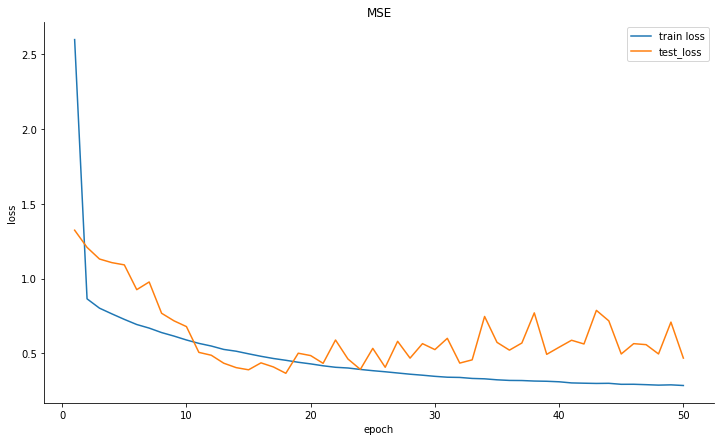

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

x = [i for i in range(1, num_epochs + 1)]

ax.plot(x, train_losses,
          label='train loss')
ax.plot(x, test_losses,
          label='test_loss')

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title('MSE')
ax.legend()

ax.spines['top'].set_visible(False) # 위 테두리 안 보이게
ax.spines['right'].set_visible(False) # 오른쪽 테두리 안 보이게

plt.show()